In [1]:
import gym
import json
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from gym import wrappers

import matplotlib.pyplot as plt


In [2]:
from env.StockTradingEnv import StockTradingEnv
from networks.DQNac import MyModel
from networks.DQNac import StockActor, StockCritic, DQN

In [3]:
df = pd.read_csv('./data/AAPL.csv')
df = df.sort_values('Date')

# The algorithms require a vectorized environment to run
env = StockTradingEnv(df)

base_action = np.array([0,0.5])

obs = env.reset()
for i in range(5):
    action, _states = (base_action, None)
    obs, rewards, done, info = env.step(action)
#print(obs)
obs = env.reset()
obs=np.expand_dims(obs,axis=0)
obs=np.expand_dims(obs,axis=0)
print(obs)

[[[[3.80342860e-03 3.74628560e-03 3.82885700e-03 3.99885720e-03
    4.02485740e-03 4.14142880e-03]
   [3.83685720e-03 3.80828600e-03 4.02428580e-03 4.08857160e-03
    4.16400000e-03 4.15171440e-03]
   [3.70485720e-03 3.69085740e-03 3.81828580e-03 3.92371440e-03
    4.01828580e-03 3.99971420e-03]
   [3.70485720e-03 3.80771440e-03 3.98657160e-03 4.02799980e-03
    4.14457140e-03 4.00714300e-03]
   [1.17641967e-01 1.05796801e-01 1.24205882e-01 1.22514460e-01
    1.37612736e-01 1.16395485e-01]
   [4.65661288e-06 4.65661288e-06 0.00000000e+00 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]]]


mod = MyModel(32, (1,4), (1,1))

print(obs)
z = mod.predict(obs)
print(z)


act = StockActor()
act_target = StockActor()
output_action = act(obs)
output_action_tar = act_target(obs)
print("output_action")
print(output_action)
print(" ")
print("output_action_tar")
print(output_action_tar)
print(" ")
output_action = act(obs)
output_action_tar = act_target(obs)
print("output_action2")
print(tf.squeeze(output_action))
print(" ")
print("output_action_tar2")
print(output_action_tar)
print(" ")

#act.model.summary()
#print(act.model.layers[3].get_weights())
#act.model.layers[3].set_weights([np.array([[-0.3]], dtype=np.float32), np.array([0.1], dtype=np.float32)])
#print(act.model.layers[3].get_weights())

crit = StockCritic()
act = StockActor()

output_action = act(obs)
print(output_action)
output_action = tf.squeeze(output_action)
output_crit = crit([obs,output_action])
print(output_crit)

    
gamma = 0.99
max_experiences = 1000
min_experiences = 365
batch_size = 32
lr = 1e-2
D = DQN( gamma, max_experiences, min_experiences, batch_size, lr)
observations = env.reset()
observations = np.expand_dims(observations,axis=0)
observations = np.expand_dims(observations,axis=0)
D.act(observations)

a = act.model.trainable_variables
print(a)
print(" ")
print(" ")
print(" hjkbedfhugqdfhiqdfbhiqdf")
print(" ")
print(" ")
b = act.trainable_variables
print(b)


#model = MyModel(32, (1,4), (1,1))
#output=tf.squeeze(model(obs))

crit = StockCritic()
crit_tar = StockCritic()
crit.action = tf.squeeze(output_action)
crit_tar.action = tf.squeeze(output_action)
output = crit(obs)
output_tar = crit_tar(obs)
print("output")
print(output)
print(" ")
print("output_tar")
print(output_tar)
print(" ")
crit.action = tf.squeeze(output_action_tar)
crit_tar.action = tf.squeeze(output_action)
output = crit(obs)
output_tar = crit_tar(obs)
print("output2")
print(output)
print(" ")
print("output_tar2")
print(output_tar)
print(" ")
print(crit.trainable_variables)

### Additional functions

In [8]:

def fill_buffer(env, DQN):
    
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    observations = np.expand_dims(observations,axis=0)
    observations = np.expand_dims(observations,axis=0)
    steps = 0
    it=0
    while it<DQN.min_experiences:
        
        #print(it)
        #observations = env.reset()

        action = DQN.act(observations) # observations is actually a single "state" ie past 5 days
        action = tf.squeeze(action)+np.random.normal(0,0.05)
        #action = np.tanh(tf.squeeze(action)+np.random.normal(0,0.05)) #avoiding small action values in the begining ->[2 0] to frequently
        #print(action)
        action = DQN.convert_action(action)
         
        #print(action)
        prev_observations = observations
        observations, reward, done, _ = env.step(action)
        #print(reward)
        observations = np.expand_dims(observations,axis=0)
        observations = np.expand_dims(observations,axis=0)
        rewards += reward    # sum of gain_net_worth

        if done :
            print("DONE")
#             reward = -200
            env.reset()
        steps += 1
        if steps >= 300: # Limiting the number of steps
            print("STEPS")
            observations = env.reset()
            observations = np.expand_dims(observations,axis=0)
            observations = np.expand_dims(observations,axis=0)
            steps = 0
        
        obs = tf.squeeze(observations)
        obs = np.expand_dims(obs,axis=0)
        prev_observations = tf.convert_to_tensor(prev_observations)
        prev_observations = tf.squeeze(prev_observations, axis=0)
        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': obs, 'done': done}
        DQN.add_experience(exp)
        
        it += 1
    return " Done "

def DDPG(M,T):                       # M number of episode T lenght of an episode
    
    gamma = 0.99
    max_experiences = 1000
    min_experiences = 365
    batch_size = 32
    lr = 1e-2
 
    D = DQN( gamma, max_experiences, min_experiences, batch_size, lr)
    a = fill_buffer(env, D)
    #print(a)
    table_loss =[]
    
    for i in range(M):
        D.train(env,T,table_loss)
    print("done")
    return table_loss

In [9]:
table_loss = DDPG(10,100)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

STEPS

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you in

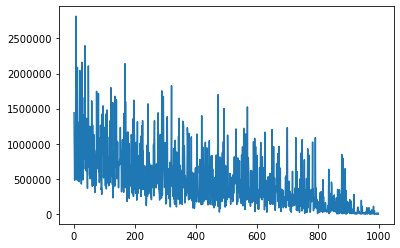

In [11]:
t= np.arange(0, 1000, 1)

plt.plot(t,table_loss)
plt.show()